# Vertices for Hubbard atom

In [1]:
using Revise
using LinearAlgebra
using SparseIR
import SparseIR: valueim
using MSSTA
import MSSTA: QuanticsInd, quantics_to_index, asqubits, index_to_quantics, QubitInd, qubit_to_index, index_to_qubit
using OvercompleteIR
import OvercompleteIR: PHConvention, freq_box
import OvercompleteIR.Atom: HubbardAtom, MagneticChannel, chi0, full_vertex, gamma
using Plots
import TensorCrossInterpolation as TCI

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [2]:
_delta(i, j) = (i == j ? 1 : 0)

_delta (generic function with 1 method)

In [3]:
using ITensors

In [4]:
U = 5.0
beta  = 10.0
ch = DensityChannel()
conv = PHConvention()
model = HubbardAtom(U, beta)

HubbardAtom(5.0, 10.0, 7.200489933738588e10, 6.25, 2.000000000027776)

In [30]:
# TCI with R bits
function create_func(func, R)
    # Origin of frequency box
    origin = -2^(R-1)

    m = MSSTA.DiscreteMesh{3}(R, (origin, origin, origin))

    function q_to_n(q::Vector{QubitInd})::NTuple{3, Int}
        offset_3d = qubit_to_index(Val(3), q, R) .- 1
        return (origin, origin, origin) .+ offset_3d
    end

    function func_q(q::Vector{QubitInd})::ComplexF64
        idx_3d = q_to_n(q)
        if iseven(idx_3d[1]) || iseven(idx_3d[2]) || isodd(idx_3d[3])
            return 0.0
        end
        return func((FermionicFreq(idx_3d[1]), FermionicFreq(idx_3d[2]), BosonicFreq(idx_3d[3])))
    end

    return q_to_n, func_q, m
end

R = 15
q2n, fq, mesh = create_func(w->gamma(ch, model, w), R)
;

In [42]:
fI = x->fq(QubitInd.(x))
localdims = fill(2, 3*R)

firstpivot = convert.(Int, index_to_qubit((2, 2, 1), R))
@show fI(firstpivot)
firstpivot = TCI.optfirstpivot(fI, localdims, firstpivot)
@show fI(firstpivot)

fI(firstpivot) = 192.5001213549511 + 0.0im
fI(firstpivot) = 11883.522530970004 + 0.0im


11883.522530970004 + 0.0im

In [58]:
qtt, ranks, errors = TCI.crossinterpolate2(
    ComplexF64, fI, localdims,
    [firstpivot], tolerance=1e-5, maxiter=500, verbosity=1
)

(TensorCrossInterpolation.TensorCI2{ComplexF64} with rank 31, [2, 4, 8, 16, 31], [0.009363811077430215, 0.0005606876917074107, 3.6561112915220256e-5, 0.0011634257855403483, 5.491356331591153e-7])

In [59]:
q_diagonal = index_to_qubit.([(2, 2, 1) .+ i for i in 0:2^(R-5):2^R-1], R)
reconst_diagonal = [TCI.evaluate(qtt, convert.(Int, q)) for q in q_diagonal]
ref_diagonal = fq.(q_diagonal)
;

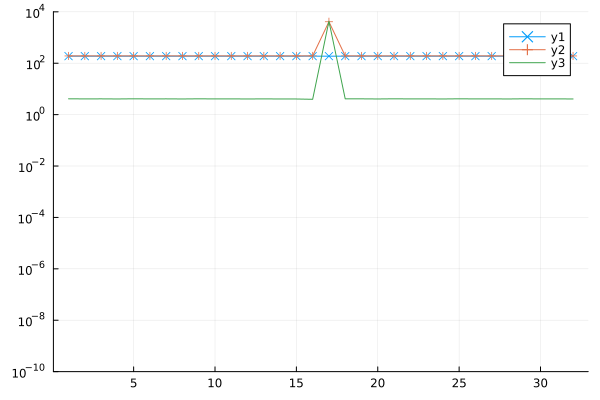

In [60]:
p = plot(yaxis=:log, ylims=(1e-10,1e+4))
plot!(p, abs.(reconst_diagonal), marker=:x)
plot!(p, abs.(ref_diagonal), marker=:+)
plot!(p, abs.(ref_diagonal .- reconst_diagonal))

In [61]:
f = collect(-101:2:101)
b = 2

is = collect(Iterators.product(f, f,  b))
ws = [MSSTA.meshindex(mesh, i) for i in is]
qs = index_to_qubit.(ws, R)

vals = [TCI.evaluate(qtt, convert.(Int, q)) for q in qs]
;

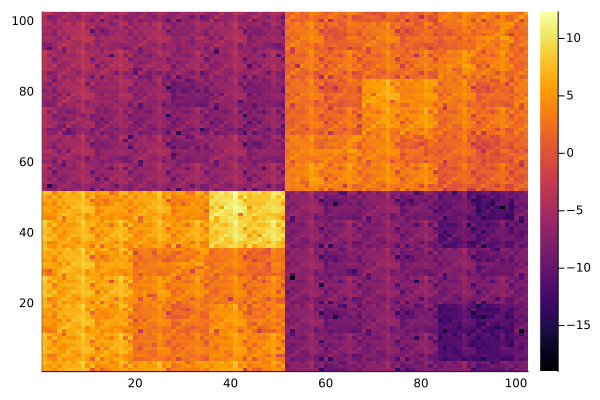

In [62]:
heatmap(log.(abs.(vals)))

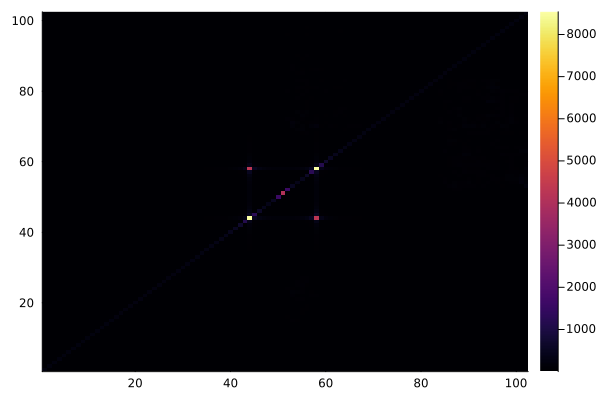

In [52]:
heatmap((abs.(vals)))